In [4]:
### Prepare module structure ###

import sys

try:
    from google.colab import drive
    drive.mount('/content/drive/')
    ondrive = True
except:
    ondrive = False
    
if ondrive:
    %cd "/content/drive/My Drive/git/PhaseRetrieval/code/"
    !pip install -q pytorch-lightning
else:
    %cd ".."

sys.path.append(".")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/git/PhaseRetrieval/code


In [25]:
import sys
import h5py
import numpy as np
import glob
import os
import io
from PIL import Image

import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder


from util import *
import data

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Download http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html and extract content to data/img_align_celeba/

In [0]:
image_path = 'data/img_align_celeba/*.jpg'
hdf5_path = "data/CelebA.h5"

In [0]:
# Read image data addresses

addrs = glob.glob(image_path)
addrs.sort()
print(len(addrs), " addresses found")
addrs[:10]

202599  addresses found


['data/img_align_celeba/000001.jpg',
 'data/img_align_celeba/000002.jpg',
 'data/img_align_celeba/000003.jpg',
 'data/img_align_celeba/000004.jpg',
 'data/img_align_celeba/000005.jpg',
 'data/img_align_celeba/000006.jpg',
 'data/img_align_celeba/000007.jpg',
 'data/img_align_celeba/000008.jpg',
 'data/img_align_celeba/000009.jpg',
 'data/img_align_celeba/000010.jpg']

In [0]:
# open a hdf5 file and create dataset of variable length

if not os.path.exists(os.path.dirname(hdf5_path)):
    os.makedirs(os.path.dirname(hdf5_path))

if hdf5_file is not None: hdf5_file.close()
hdf5_file = h5py.File(hdf5_path, mode='w')

dt = h5py.special_dtype(vlen=np.dtype('uint8'))
hdf5_file.create_dataset("images", (len(addrs),), dt)

<HDF5 dataset "images": shape (202599,), type "|O">

In [0]:
# Iterate over all addresses and save each JPG file as binary data
for i in range(len(addrs)):
    if i % 1000 == 0 and i > 1:
        print("Processed data: {}/{}".format(i, len(addrs)))
    fin = open(addrs[i], 'rb')
    binary_data = fin.read()
    hdf5_file["images"][i] = np.fromstring(binary_data, dtype='uint8')
    
hdf5_file.close()

/home/alex/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys


Processed data: 1000/202599
Processed data: 2000/202599
Processed data: 3000/202599
Processed data: 4000/202599
Processed data: 5000/202599
Processed data: 6000/202599
Processed data: 7000/202599
Processed data: 8000/202599
Processed data: 9000/202599
Processed data: 10000/202599
Processed data: 11000/202599
Processed data: 12000/202599
Processed data: 13000/202599
Processed data: 14000/202599
Processed data: 15000/202599
Processed data: 16000/202599
Processed data: 17000/202599
Processed data: 18000/202599
Processed data: 19000/202599
Processed data: 20000/202599
Processed data: 21000/202599
Processed data: 22000/202599
Processed data: 23000/202599
Processed data: 24000/202599
Processed data: 25000/202599
Processed data: 26000/202599
Processed data: 27000/202599
Processed data: 28000/202599
Processed data: 29000/202599
Processed data: 30000/202599
Processed data: 31000/202599
Processed data: 32000/202599
Processed data: 33000/202599
Processed data: 34000/202599
Processed data: 35000/2

### Test created CelebA.h5 file

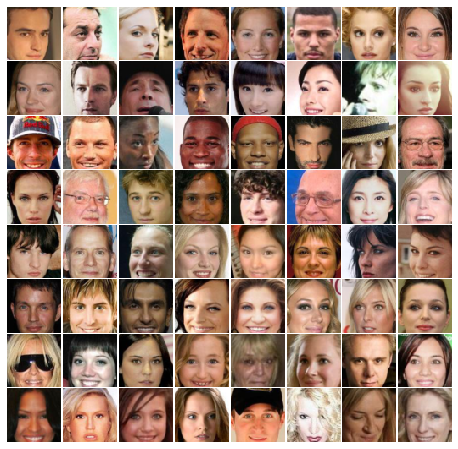

In [21]:
dataloder, imsize = data.load(name='CelebA', path=hdf5_path, batch_size=64)
plot_grid2(next(iter(dataloder['train'])))

### Append magnitudes to CelebA.h5

In [0]:
celeba64_path = "data/CelebA64.h5"
celeba_file = h5py.File(hdf5_path, 'r')
length = 202599

indices = list(range(length))
train_idx, valid_idx, test_idx = indices[:162769], indices[162769:182636], indices[182636:]

# Crop image to wanted size
trans = transform=transforms.Compose([transforms.CenterCrop((108, 108)), transforms.Resize(64)])

In [14]:
# open a new hdf5 file for croped CelebA

if not os.path.exists(os.path.dirname(celeba64_path)):
    os.makedirs(os.path.dirname(celeba64_path))

celeba64_file = h5py.File(celeba64_path, mode='w')
celeba64_file.create_dataset('train', (len(train_idx), 64, 64, 3), np.dtype('uint8'))
celeba64_file.create_dataset('val', (len(valid_idx), 64, 64, 3), np.dtype('uint8'))
celeba64_file.create_dataset('test', (len(test_idx), 64, 64, 3), np.dtype('uint8'));

<HDF5 dataset "test": shape (19963, 64, 64, 3), type "|u1">

In [19]:
# Iterate over all addresses and save each JPG file as binary data

for i, j in enumerate(train_idx):
    celeba64_file['train'][i] = trans(Image.open(io.BytesIO(celeba_file['images'][j])))
    if j % 1000 == 0 and i > 1:
        print("Processed data: {}/{}".format(j, length))
for i, j in enumerate(valid_idx):
    celeba64_file['val'][i] = trans(Image.open(io.BytesIO(celeba_file['images'][j])))
    if j % 1000 == 0 and i > 1:
        print("Processed data: {}/{}".format(j, length))
for i, j in enumerate(test_idx):
    celeba64_file['test'][i] = trans(Image.open(io.BytesIO(celeba_file['images'][j])))
    if j % 1000 == 0 and i > 1:
        print("Processed data: {}/{}".format(j, length))

celeba_file.close()
celeba64_file.close()

Processed data: 1000/202599
Processed data: 2000/202599
Processed data: 3000/202599
Processed data: 4000/202599
Processed data: 5000/202599
Processed data: 6000/202599
Processed data: 7000/202599
Processed data: 8000/202599
Processed data: 9000/202599
Processed data: 10000/202599
Processed data: 11000/202599
Processed data: 12000/202599
Processed data: 13000/202599
Processed data: 14000/202599
Processed data: 15000/202599
Processed data: 16000/202599
Processed data: 17000/202599
Processed data: 18000/202599
Processed data: 19000/202599
Processed data: 20000/202599
Processed data: 21000/202599
Processed data: 22000/202599
Processed data: 23000/202599
Processed data: 24000/202599
Processed data: 25000/202599
Processed data: 26000/202599
Processed data: 27000/202599
Processed data: 28000/202599
Processed data: 29000/202599
Processed data: 30000/202599
Processed data: 31000/202599
Processed data: 32000/202599
Processed data: 33000/202599
Processed data: 34000/202599
Processed data: 35000/2

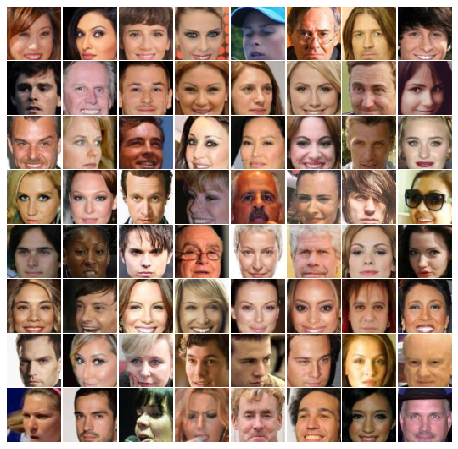

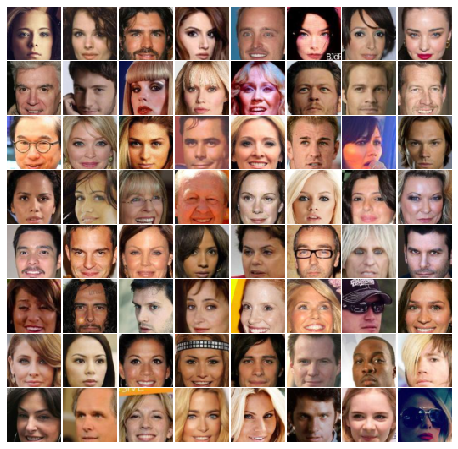

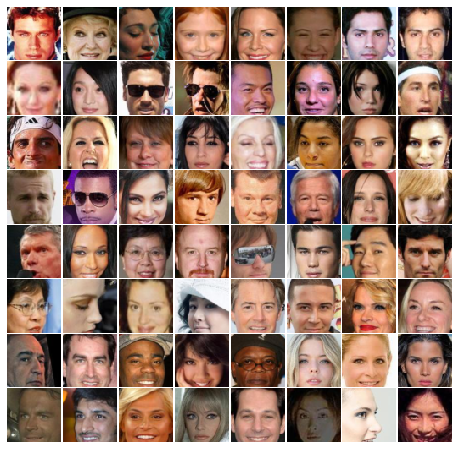

In [38]:
# Test created file

dataloder, imsize = data.load(name='CelebA64', path=celeba64_path, batch_size=64)
plot_grid2(next(iter(dataloder['train'])))
plot_grid2(next(iter(dataloder['val'])))
plot_grid2(next(iter(dataloder['test'])))